#Can how you spend your free time predict who you'll vote for?
##Edwin Savelson
Summary: In this project, I am exploring data published by the United States Bureau of Labor Statistics published in their annual American Time Use Survey(ATUS).  The ATUS collects information on how Americans are using their time- e.g. Hobbies, Jobs, etc.  

Goal: I will let a model perform binary classification using a variety of features on the provided data with minimal intervention then compare that classification to the results of the 2024 Presidential Election with each state's cast vote representing a binary classification.

*This project uses the [data published here](https://www.bls.gov/tus/data/datafiles-2023.htm).*

## Important notes/declarations about this data exploration:
- There is no infomation on the respondents' actual or lack of actual vote cast.
- It is not known who within the sample voted.
- If the person voted, it is not known for whom they voted.
- There is not an equal number respondents on each state.
- Only data from the 2023 ATUS will be included.

#### Assumptions:
- All of the respondents were truthful.
- The respondent voted for the candidate who won a majority of the State's electoral votes. It is possible to separate the State's voting population into two groups and run a simulation based on the probability that a randomly selected member of the population voted for the winning candidate and assume their voting preference- but, for simplicity, I will assume that all respondents from a given state voted for the majority candidate.  E.G. All respondents from Colorado voted for the Democratic Candidate.

#### Data that is being ignored:
- States with little to no data(parameters to be determined) will be omitted.

# Predictions:
- Just as the electoral map largely matches the map of average income(Individuals in Red States tend to make less than Blue States), I predict that amount of free time and income level will be reflected in the hobbies in which the respondents participate and thus will predict their vote.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

## <font color='red'>Exploratory Data Analysis (EDA)</font>
### How is the data seperated?
This data is HARD to decipher, mostly because the headings are meaningless without the dictionary of initialisms provided [here](https://github.com/EdwinSavelson/CS3120_Final_Project/blob/main/freqvariables.pdf).  
There are **592** columns(Infinitely more given the encoding later in the project) in this data so attempting to analyze all of these features would be an undertaking outside the scope of this project.

### A few headings relevant to my exploration include:

| Code | Explanation  | Possible Responses |
|------|------|-----|
|GESTFIPS |State from which the respondent responded to the survey | [FIPS State code](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)|
|GEREG| Geographic Region|1 = Northeast, 2 = Midwest, 3 = South, 4 = West|
|EMPSTAT| Employment Status|1 = Employed, 2 = Employed(Absent), 3 = Unempoyed on Layoffs, 4 = Unemployed(looking), 5 = Not in Labor Force|
|ACTIVITY|Activity in which the respondent participated| All codes [here](https://www.bls.gov/tus/lexicons/lexiconwex2023.pdf)|




In [2]:
df1 = pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/atuscperson_2023.dat')
df2= pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/atusactivity_2023.dat')
df3 = pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/atusresp_2023.dat')
data= pd.merge(df1, df2, on='TUCASEID')
data= pd.merge(data, df3, on='TUCASEID')
print(f"** df has {data.shape[0]} rows and {data.shape[1]} columns **")
data.head()


** df has 371676 rows and 592 columns **


,TUCASEID,TULINENO_x,GEREG,GEDIV,GESTFIPS,GTMETSTA,GTCBSA,GTCO,HEFAMINC,HEHOUSUT,...,TXSPUHRS,TXTCC,TXTCCTOT,TXTCOC,TXTHH,TXTNOHH,TXTO,TXTOHH,TXTONHH,TREMODR
0,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1
1,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1
2,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1
3,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1
4,20230101230035,1,3,5,45,1,16700,0,7,1,...,-1,-1,0,0,-1,-1,-1,-1,-1,1


The sample size of this data(approx 372k) is small relative to the population of the United States who voted in the (approx 158M), assumably because the survey is quite work intensive for the participant.

In [3]:
# Declare some variables for easy access
state = "GESTFIPS"
activity = "TUTIER1CODE"
employment = "TELFS"

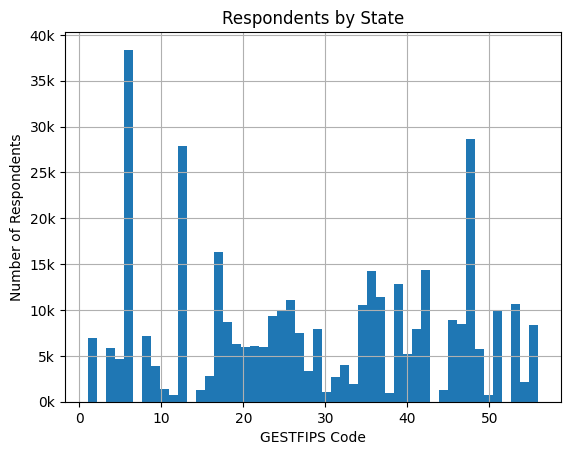

,0
GESTFIPS,
1,6086
2,912
4,5901
5,4622
6,38384
8,7155
9,3910
10,1433
11,723


In [4]:
ax = data[state].hist(bins=50)

ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x /1000)}k'))

plt.xlabel('GESTFIPS Code')
plt.ylabel('Number of Respondents')
plt.title('Respondents by State')

plt.show()
data.columns = data.columns.str.strip()

data.groupby(state).size()


## Import actual election results

In [5]:
election_results_df = pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/us_states_party_labels.csv')
state_voting_map = pd.Series(election_results_df.Party.values, index=election_results_df.State).to_dict()
print(state_voting_map)

{'Alabama': 'Republican', 'Alaska': 'Republican', 'Arizona': 'Republican', 'Arkansas': 'Republican', 'California': 'Democrat', 'Colorado': 'Democrat', 'Connecticut': 'Democrat', 'Delaware': 'Democrat', 'District of Columbia': 'Democrat', 'Florida': 'Republican', 'Georgia': 'Republican', 'Hawaii': 'Democrat', 'Idaho': 'Republican', 'Illinois': 'Democrat', 'Indiana': 'Republican', 'Iowa': 'Republican', 'Kansas': 'Republican', 'Kentucky': 'Republican', 'Louisiana': 'Republican', 'Maine': 'Democrat', 'Maryland': 'Democrat', 'Massachusetts': 'Democrat', 'Michigan': 'Republican', 'Minnesota': 'Democrat', 'Mississippi': 'Republican', 'Missouri': 'Republican', 'Montana': 'Republican', 'Nebraska': 'Republican', 'Nevada': 'Republican', 'New Hampshire': 'Democrat', 'New Jersey': 'Democrat', 'New Mexico': 'Democrat', 'New York': 'Democrat', 'North Carolina': 'Republican', 'North Dakota': 'Republican', 'Ohio': 'Republican', 'Oklahoma': 'Republican', 'Oregon': 'Democrat', 'Pennsylvania': 'Republican

## Preprocessing

*   Edit data so that FIPS codes are read as state names rather than numbers
*   Drop rows with missing information in any of the desired features
*   Ensure that categorical data is processed as such- everything is a code(e.g. employed = 1, unemployed = 2), so I ran into a lot of errors in processing the code as an int rather than a string.

In [14]:
# Map the FIPS codes to state names
fips_mapping = pd.read_csv('https://raw.githubusercontent.com/EdwinSavelson/CS3120_Final_Project/refs/heads/main/fips_to_state.csv')
fips_to_state = pd.Series(fips_mapping.state.values, index=fips_mapping.fips).to_dict()
data['state_name'] = data[state].map(fips_to_state)
# Add column for voting results
data['voting_preference'] = data['state_name'].map(state_voting_map)

# Handle missing values
# data = data.dropna(subset=[employment, activity])

# Handle data as categorical(codes)
data[activity] = data[activity].astype('category')
data[employment] = data[employment].astype('category')

# Check for NaN values
if (data.isnull().sum() > 0).any():
    print(data.isnull().sum())

data.groupby(activity).size()

KeyError: 'TUTIER1CODE'

# <font color='red'>Modeling</font>
## Feature Engineering


In [ ]:

# Cluster individuals based on selected features
selected_features = [employment,activity]

# One-Hot encoding because the columns are categorical and k-means does not work with it otherwise
data = pd.get_dummies(data, columns=[employment, activity])

# Reselect columns after renaming
selected_features = [col for col in data.columns if col.startswith((employment, activity))]

# Apply K-means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
data['cluster'] = kmeans.fit_predict(data[selected_features])

# Count clusters per state
cluster_counts = (
    data.groupby(['state_name', 'cluster'])
    .size()  # Count the occurrences of each cluster within each state
    .unstack(fill_value=0)  # Pivot the table to get clusters as columns
    .reset_index()
)

# Aggregate features by state
aggregated_data = (
    data.groupby('state_name')
    .agg({col: 'mean' for col in selected_features})  # Aggregate one-hot encoded columns
    .reset_index()
)

# Merge the two DataFrames
state_level_data = pd.merge(cluster_counts, aggregated_data, on='state_name')

# Add voting preference Republican or Democrat
state_level_data['voting_preference'] = state_level_data['state_name'].map(state_voting_map)

# Binary Classification/Model Training


In [12]:
X = state_level_data.drop(columns=['state_name', 'voting_preference'])
X.columns = X.columns.astype(str)
# Drop rows containing missing values
X = X.dropna()

y = state_level_data['voting_preference']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # STRATIFY TO KEEP 50 States
#
# X_with_state = X.copy()
# X_with_state['state_name'] = state_level_data['state_name']

# # Stratified split
# X_train, X_test, y_train, y_test = train_test_split(
#     X_with_state, y,
#     test_size=0.3,
#     random_state=42,
#     stratify=X_with_state['state_name']
# )

# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)

# Step 4: Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    Democrat       0.67      0.22      0.33         9
  Republican       0.46      0.86      0.60         7

    accuracy                           0.50        16
   macro avg       0.56      0.54      0.47        16
weighted avg       0.58      0.50      0.45        16



16
Predictions by State:
              state_name      actual   predicted
0               Arkansas  Republican  Republican
1             California    Democrat    Democrat
2            Connecticut    Democrat  Republican
3   District of Columbia    Democrat  Republican
4                  Idaho  Republican    Democrat
5               Illinois    Democrat  Republican
6               Kentucky  Republican  Republican
7            Mississippi  Republican  Republican
8             New Jersey    Democrat  Republican
9             New Mexico    Democrat  Republican
10              New York    Democrat  Republican
11        South Carolina  Republican  Republican
12                 Texas  Republican  Republican
13              Virginia    Democrat  Republican
14            Washington    Democrat    Democrat
15             Wisconsin  Republican  Republican


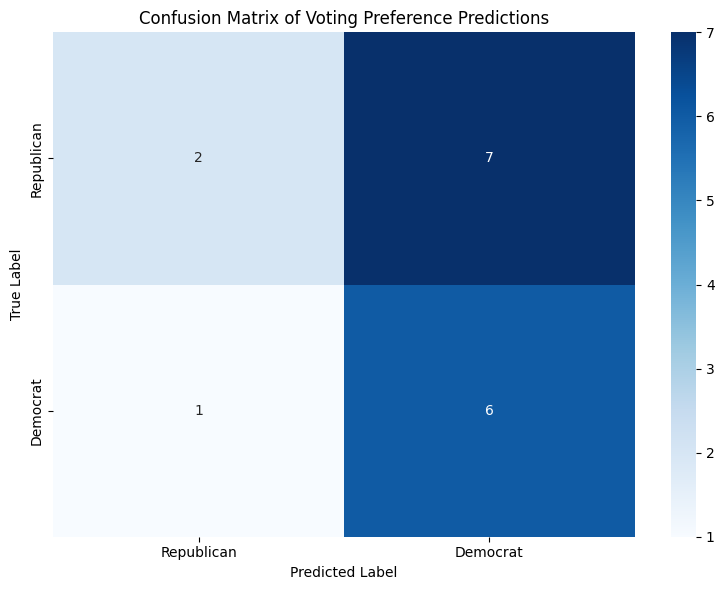

<ipython-input-13-162e6d0c7e78>:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  state_accuracy = predictions_df.groupby('state_name').apply(


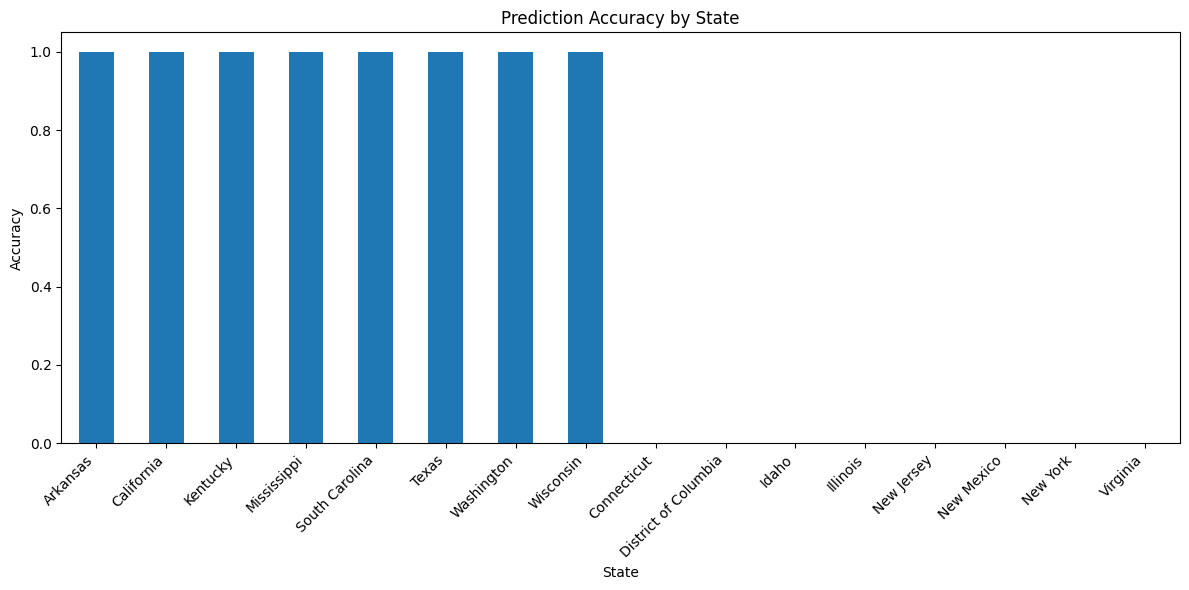

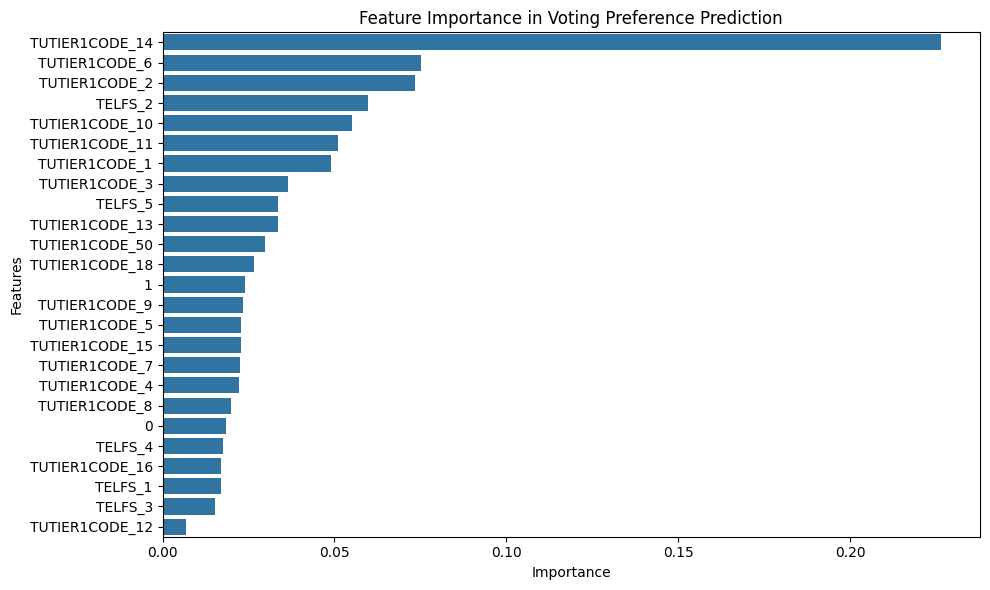


Model Performance Metrics:
              precision    recall  f1-score   support

    Democrat       0.67      0.22      0.33         9
  Republican       0.46      0.86      0.60         7

    accuracy                           0.50        16
   macro avg       0.56      0.54      0.47        16
weighted avg       0.58      0.50      0.45        16


Top 5 Most Important Features:
           feature  importance
20  TUTIER1CODE_14    0.226434
12   TUTIER1CODE_6    0.075105
8    TUTIER1CODE_2    0.073436
3          TELFS_2    0.059799
16  TUTIER1CODE_10    0.055152


In [13]:

# Create a DataFrame with predictions and actual values
predictions_df = pd.DataFrame({
    'state_name': state_level_data.loc[X_test.index, 'state_name'],
    'actual': y_test,
    'predicted': y_pred
})


print(predictions_df['state_name'].nunique())
# Detailed predictions by state
print("Predictions by State:")
detailed_predictions = predictions_df.groupby('state_name').agg({
    'actual': 'first',  # Actual voting preference for the state
    'predicted': lambda x: x.mode()[0]  # Most common prediction
}).reset_index()
print(detailed_predictions)

# Visualization 1: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Republican', 'Democrat'],
            yticklabels=['Republican', 'Democrat'])
plt.title('Confusion Matrix of Voting Preference Predictions')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# Visualization 2: Prediction Accuracy by State
plt.figure(figsize=(12, 6))
state_accuracy = predictions_df.groupby('state_name').apply(
    lambda x: np.mean(x['actual'] == x['predicted'])
).sort_values(ascending=False)

state_accuracy.plot(kind='bar')
plt.title('Prediction Accuracy by State')
plt.xlabel('State')
plt.ylabel('Accuracy')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualization 3: Feature Importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance in Voting Preference Prediction')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

# Additional Analysis
print("\nModel Performance Metrics:")
print(classification_report(y_test, y_pred))

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# **IGNORE EVERYTHING BELOW THIS LINE I JUST CLONED ASSIGNMENT 4 AS A STARTING POINT FOR THE PROJECT**

<hr style="height:2px;border-width:0;color:black;background-color:black">






***
### Q1: Use `groupby` on the feature, `BedroomAbvGr`, to see how many houses have 1 bedroom, 2 bedrooms, etc.***
1. ***What seems to be the average, or most typical number of bedrooms a home has?***
3 Bedrooms
2. ***How many houses in this dataset have this number of bedrooms?***
804
\<INPUT YOUR ANSWER TO Q1 HERE\>
***

In [ ]:
print(df.columns)
df.groupby('BedroomAbvGr').size()

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

,0
BedroomAbvGr,
0,6
1,50
2,358
3,804
4,213
5,21
6,7
8,1


We won't do it here, but plotting each feature individually, and plotting it against the response or target variable, is another helpful way to understand what is happening with the data. However, it can also be quite time consuming.

There are now tools to help automate some of this. The first we'll mention is the VS Code extension, [Data Wrangler](https://marketplace.visualstudio.com/items?itemName=ms-toolsai.datawrangler). This allows you to quickly look at the data and see what the distribution of each column looks like, see how may missing values each column has, how many distinct values, etc.

If we wanted to use a tool that only depended on Python (and was not an IDE extension), then there are other options.
The Python module, [YData-Profiling (formerly Pandas Profiling)](https://github.com/ydataai/ydata-profiling), even goes beyond what Data Wrangler does. Here is an [example of this EDA tool on the Titanic dataset](https://docs.profiling.ydata.ai/latest/examples/titanic/titanic_report.html). You should definitly consider using this type of tool for your course project in this class.

Before we continue let's pick out a subset of columns that we'll use to model. In other words, wwe won't use all of the features right away, but we'll instead just use the numeric features, and perhaps one categorical feature.

In [ ]:
# get a list of the column names that are either integers or floats
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_df = df.select_dtypes(include=numerics).copy()
numeric_df.describe()


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
# Get the column, Neighborhood from df and convert it to a one-hot encoded DataFrame
neighborhood = df['Neighborhood']
neighborhood = pd.get_dummies(neighborhood).astype(int)
neighborhood.shape

# Add the one-hot encoded DataFrame to numeric_df
numeric_df = pd.concat([numeric_df, neighborhood], axis=1)
numeric_df.shape

(1460, 63)

Of all of those 38 columns, which includes the outcome, SalesPrice, let's see which ones have missing values. We could manually look at this with Data Wrangler, but the following code cell quickly checks how many missing values each column has.

Note that dealing with missing values is an entire subject on its own. We will touch on it a little more, but you would likely see more about it in an advanced Statistics or ML course. To give you a peek of what it entails, check out this reference on [Dealing with Missing Data](https://www.dasca.org/world-of-data-science/article/strategies-for-handling-missing-values-in-data-analysis).


Since we are not going to deal with missing values directly (by trying to replace the missing values with a 'best guess'), we will simply exclude columns that have _too many_ missing values. Exactly how many is _too many_ is up to us, but we'll opt for a max of 50.

In [ ]:
# See which columns in numeric_df have more than 50 missing values
missing = numeric_df.isnull().sum()
missing = missing[missing > 50]
print(missing)

# Remove these columns from the DataFrame
ncols_before = numeric_df.shape[1]
numeric_df = numeric_df.drop(columns=missing.index)
ncols_after = numeric_df.shape[1]
print(f"** Removed {ncols_before - ncols_after} columns **")

LotFrontage    259
GarageYrBlt     81
dtype: int64
** Removed 2 columns **


We'll now remove the rows from the data that have any missing values. Again, you may deal with missing values in a different way depending on how much data you have, which column it is that has missing values, etc. But, for us, we'll simply remove the rows with missing data.

In [ ]:
# Remove rows with missing values
nrows_before = numeric_df.shape[0]
numeric_df = numeric_df.dropna()
nrows_after = numeric_df.shape[0]
print(f"** Removed {nrows_before - nrows_after} rows **")
numeric_df.shape

** Removed 8 rows **


(1452, 61)

We'll now copy over the predictors (or features, or independent variables) to a __Pandas Data Frame__, `X`, and the outcome (or response, or dependent variable, target variable, etc.) to a __Pandas Data Series__, `y`.

In [ ]:
X = numeric_df.drop(columns=['Id','SalePrice']).copy() # remove the index Id and outcome SalePrice
y = numeric_df['SalePrice'].copy()


***
### Q2: What is the `shape` of X and y? In the following code cell input the code needed to see the shape of X and y. Then for your answer here state the number of rows and columns in each X and y.

X Shape = (1452, 59)
y Shape = (1452,) y is just one column/samples
***

In [ ]:
# output the shape of X and y here
print(X.shape)
print(y.shape)

(1452, 59)
(1452,)


Next we'll add a few more features to our data. Note that these are not entirely new features, but features that are transformations of the current features in some way. We're not going into much detail here, but there is also a lot that can be said about the practice of _[Feature Engineering](https://en.wikipedia.org/wiki/Feature_engineering)_, which is where you take the features you have and manipulate/combined/transform them in some way to create new features that (ideally) are able to predict y even better than the original features.

In [ ]:
# Add columns to X for square root of 1stFlrSF, LotArea, GrLivArea, WoodDeckSF, OpenPorchSF, GarageArea
X['sqrt_1stFlrSF'] = np.sqrt(X['1stFlrSF'])
X['sqrt_LotArea'] = np.sqrt(X['LotArea'])
X['sqrt_GrLivArea'] = np.sqrt(X['GrLivArea'])
X['sqrt_WoodDeckSF'] = np.sqrt(X['WoodDeckSF'])
X['sqrt_OpenPorchSF'] = np.sqrt(X['OpenPorchSF'])
X['sqrt_GarageArea'] = np.sqrt(X['GarageArea'])
X.shape

# Add columns to X for the quadratic of 1stFlrSF, LotArea, GrLivArea, WoodDeckSF, OpenPorchSF, GarageArea
X['quad_1stFlrSF'] = X['1stFlrSF']**2
X['quad_LotArea'] = X['LotArea']**2
X['quad_GrLivArea'] = X['GrLivArea']**2
X['quad_WoodDeckSF'] = X['WoodDeckSF']**2
X['quad_OpenPorchSF'] = X['OpenPorchSF']**2
X['quad_GarageArea'] = X['GarageArea']**2
X.shape

(1452, 71)

Let's now sort the columns of `X`, i.e. the features, so that the first column is the one with the highest correlation with `y`, the second column has the second highest correlation with `y`, and so on.

In [ ]:
# Sort the columns of X according to how strong their correlation is with SalePrice
correlations = X.corrwith(y).abs().sort_values(ascending=False)
X = X[correlations.index]
pd.options.display.max_columns = None

X.head()

,OverallQual,GrLivArea,sqrt_GrLivArea,quad_GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,sqrt_1stFlrSF,quad_GarageArea,FullBath,quad_1stFlrSF,sqrt_GarageArea,TotRmsAbvGrd,YearBuilt,YearRemodAdd,MasVnrArea,Fireplaces,sqrt_OpenPorchSF,NridgHt,BsmtFinSF1,sqrt_LotArea,sqrt_WoodDeckSF,NoRidge,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,quad_WoodDeckSF,BsmtFullBath,StoneBr,BsmtUnfSF,OldTown,NAmes,Edwards,BedroomAbvGr,IDOTRR,quad_OpenPorchSF,BrkSide,Somerst,KitchenAbvGr,EnclosedPorch,Sawyer,Timber,quad_LotArea,ScreenPorch,MeadowV,BrDale,PoolArea,MSSubClass,OverallCond,CollgCr,Crawfor,Veenker,SWISU,Mitchel,ClearCr,3SsnPorch,MoSold,NPkVill,Gilbert,YrSold,LowQualFinSF,NWAmes,MiscVal,Blueste,Blmngtn,BsmtHalfBath,SawyerW,BsmtFinSF2
0,7,1710,41.352146,2924100,2,548,856,856,29.257478,300304,2,732736,23.409400,8,2003,2003,196.0,0,7.810250,0,706,91.923882,0.000000,0,0,854,61,1,8450,0,1,0,150,0,0,0,3,0,3721,0,0,1,0,0,0,71402500,0,0,0,0,60,5,1,0,0,0,0,0,0,2,0,0,2008,0,0,0,0,0,0,0,0
1,6,1262,35.524639,1592644,2,460,1262,1262,35.524639,211600,2,1592644,21.447611,6,1976,1976,0.0,1,0.000000,0,978,97.979590,17.262677,0,298,0,0,0,9600,88804,0,0,284,0,0,0,3,0,0,0,0,1,0,0,0,92160000,0,0,0,0,20,8,0,0,1,0,0,0,0,5,0,0,2007,0,0,0,0,0,1,0,0
2,7,1786,42.261093,3189796,2,608,920,920,30.331502,369664,2,846400,24.657656,6,2001,2002,162.0,1,6.480741,0,486,106.066017,0.000000,0,0,866,42,1,11250,0,1,0,434,0,0,0,3,0,1764,0,0,1,0,0,0,126562500,0,0,0,0,60,5,1,0,0,0,0,0,0,9,0,0,2008,0,0,0,0,0,0,0,0
3,7,1717,41.436699,2948089,3,642,756,961,31.000000,412164,1,923521,25.337719,7,1915,1970,0.0,1,5.916080,0,216,97.724101,0.000000,0,0,756,35,0,9550,0,1,0,540,0,0,0,3,0,1225,0,0,1,272,0,0,91202500,0,0,0,0,70,5,0,1,0,0,0,0,0,2,0,0,2006,0,0,0,0,0,0,0,0
4,8,2198,46.882833,4831204,3,836,1145,1145,33.837849,698896,2,1311025,28.913665,9,2000,2000,350.0,1,9.165151,0,655,119.415242,13.856406,1,192,1053,84,1,14260,36864,1,0,490,0,0,0,4,0,7056,0,0,1,0,0,0,203347600,0,0,0,0,60,5,0,0,0,0,0,0,0,12,0,0,2008,0,0,0,0,0,0,0,0


***
### Q3: Does the feature engineering step seem like it was a good idea for this dataset of Home Sale Prices? Answer yes or no, and explain why.

Yes it does because it gives us features to focus on when tuning. (With the exception of the "OverallQual" feature. It seems pretty arbitrary)
***

## Model Tuning

Let's now try a few different types of models and try to "_tune_~ each one. When we say "_tune_" a model, what we mean is that we want to find the ideal value of the model's [hyperparameter(s)](https://en.wikipedia.org/wiki/Hyperparameter_(machine_learning)). Remember that a `hyperparameter` is a parameter of a model that is not fit/learned directly from the data. Rather, it is a value that determines _how the model will learn_ from the. Some examples are:
* `max_depth` of a Decision Tree - the maximum depth of a decision tree is not directly learned from the data, but it will affect how the model learns, and ultimately how many parameters will be in the tree
* `num_estimators` in an Ensemble model (e.g. Random Forest or GradientBoosting Tree) - again, this will affect how many total parameters will be in the final (ensemble) model

Note that there are often times more than one hyperparameter. Below we are trying many values of a hyperparameter, e.g. $n_{h1}$ possible values. However, if there were multiple hyperparameters and the second one had $n_{h2}$ possible values, and the third had $n_{h3}$, ..., and the $k^{th}$ had $n_{hk}$ possible values, then there would be an a huge number of possible combinations that we would need to consider (namely, $n_{h1}\cdot n_{h2}\cdot \dots \cdot n_{hk}$). Fortunately, most models do not have too many hyperparameters to consider, or perhaps not many values of each to consider, so in practice this is typically not too onerous. But, be careful about trying to tune a model for every possible hyperparameter.

Before we begin to do any model training, remember that it is critical that we split the data into separate training and test datasets.

Note that code below is splitting the data into 80% training data and 20% test data. This is the typical split although there may be times where a different proportion would make more sense.

In [ ]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2)

### Least Squares Regression Model

We'll now fit a basic Least Squares regression model to this data.

In [ ]:
# Fit a regression model to the data using only the first column of X to predict y
model_ls = LinearRegression()
num_features = X.shape[1]

rmse_values_ls = []
pred_rmse_values_ls = []
min_features = 1
for i in range(min_features, num_features + 1):
    model_ls.fit(X_train.iloc[:,0:i], y_train)
    mse = np.sqrt(np.mean((y_train - model_ls.predict(X_train.iloc[:,0:i]))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_ls.predict(X_test.iloc[:,0:i]))**2))
    rmse_values_ls.append(mse)
    pred_rmse_values_ls.append(pred_mse)

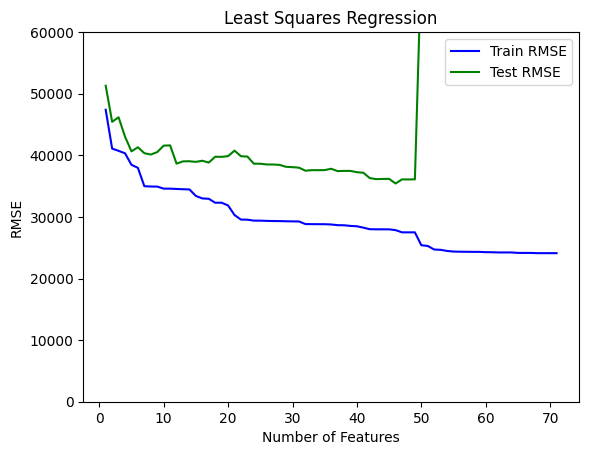

In [ ]:
# Plot the rmse values
plt.plot(range(min_features, num_features + 1), rmse_values_ls, label='Train RMSE', color='blue')
plt.plot(range(min_features, num_features + 1), pred_rmse_values_ls, label='Test RMSE', color='green')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.ylim(0, 60000)
plt.title('Least Squares Regression')
plt.legend()
plt.show()

In [ ]:
rmse_values_dt = []
pred_rmse_values_dt = []
max_depths = range(1, 50)
for i in range(len(max_depths)):
    model_dt = DecisionTreeRegressor(max_depth=max_depths[i])
    model_dt.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_dt.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_dt.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

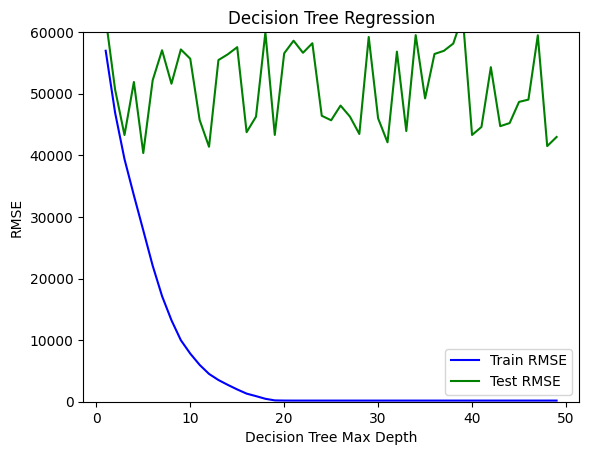

In [ ]:
# Plot the rmse values
plt.plot(range(min(max_depths), max(max_depths)+1), rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(range(min(max_depths), max(max_depths)+1), pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Decision Tree Max Depth')
plt.ylabel('RMSE')
plt.title('Decision Tree Regression')
plt.ylim(0, 60000)
plt.legend()
plt.show()

In [ ]:
rmse_values_dt = []
pred_rmse_values_dt = []
poss_num_estimators = list(range(1, 102, 5))
for i in range(len(poss_num_estimators)):
    #print(f"** num_estimators = {poss_num_estimators[i]} **")
    model_rf = RandomForestRegressor(n_estimators=poss_num_estimators[i], min_samples_leaf=1, random_state=2)
    model_rf.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_rf.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_rf.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

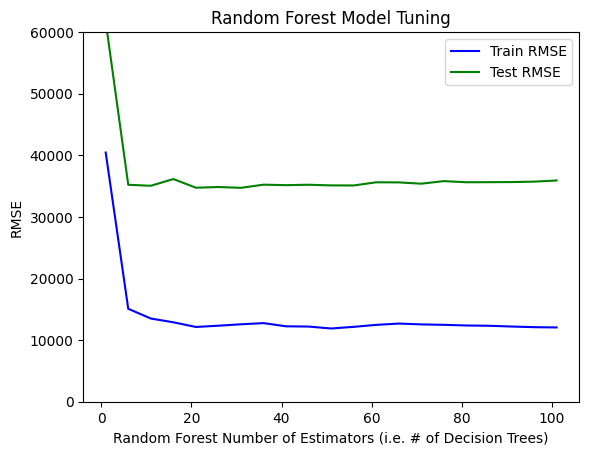

In [ ]:
# Plot the rmse values
plt.plot(poss_num_estimators, rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(poss_num_estimators, pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Random Forest Number of Estimators (i.e. # of Decision Trees)')
plt.ylabel('RMSE')
plt.title('Random Forest Model Tuning')
plt.ylim(0, 60000)
plt.legend()
plt.show()

In [ ]:
# Let's try a Gradient Boosting Regressor
rmse_values_dt = []
pred_rmse_values_dt = []
poss_num_estimators = list(range(1, 402, 10))
for i in range(len(poss_num_estimators)):
    #print(f"** num_estimators = {poss_num_estimators[i]} **")
    model_gb = GradientBoostingRegressor(n_estimators=poss_num_estimators[i], learning_rate=0.1, random_state=2)
    model_gb.fit(X_train, y_train)
    mse = np.sqrt(np.mean((y_train - model_gb.predict(X_train))**2))
    pred_mse = np.sqrt(np.mean((y_test - model_gb.predict(X_test))**2))
    rmse_values_dt.append(mse)
    pred_rmse_values_dt.append(pred_mse)

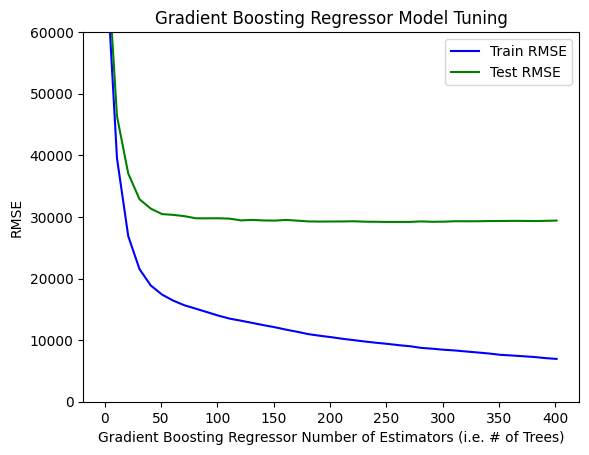

In [ ]:
# Plot the rmse values
plt.plot(poss_num_estimators, rmse_values_dt, label='Train RMSE', color='blue')
plt.plot(poss_num_estimators, pred_rmse_values_dt, label='Test RMSE', color='green')
plt.xlabel('Gradient Boosting Regressor Number of Estimators (i.e. # of Trees)')
plt.ylabel('RMSE')
plt.title('Gradient Boosting Regressor Model Tuning')
plt.ylim(0, 60000)
plt.legend()
plt.show()

***
### Q4: Based on the results above, which model would you choose, and which hyperparameter value for that model would you use? Explain your answer.

Least Squares Regression at around 49 features, I believe, has the best compromise of the test and train being close while still being relatively low.  Gradient botts at around 50 might be considered but it is farther apart than LSR.
***

## Estimating a Model's Future Accuracy

From the above we might have a decent idea of how well a model will perform on future data. After all, we did have separate `train` and `test` datasets, so it seems like we can confidently say what the accuracy will be on future data.

However, we have to remember that our `test` dataset is just one possible example of future data that our model might encounter. We know that the accuracy on a different _future_ dataset will not be the exact same as the accuracy we saw above on the test dataset. Therefore, what we really need to do is to _estimate_ what our model's future accuracy will be. Which means that we have to get an idea of how much the accuracy (or RMSE) will vary from one _test_ dataset to another. As you know from basic Statistics, this sounds a lot like trying to undestand the variance of the model's performance metric for all possible future test datasets.

But, where can we get more test data? We need training data, and ideally the more training data the better. So, we can't simply just change the training/test split from, say, 80/20, to be 50/50 or 20/80.
What can we do? This is where the idea of **[Cross Validation](https://en.wikipedia.org/wiki/Cross-validation_(statistics))** comes into play. Let's now use Scikit Learn's `cross_val_score` function to split our data one time into one possible training and test split; then do it again with a different training and test split; then again, up to $k$ possible times. This is called **K-fold Cross-validation** and it gives us **k** different test datasets of size $\frac{1}{k}\cdot n$, where $n$ is the size of our original dataset.


In [ ]:
# set k to be the number of folds for cross-validation (i.e. the number of different test dataset we'll use)
k = 10

In [ ]:
model_ls = LinearRegression()
scores_ls = cross_val_score(model_ls, X.iloc[:,:30], y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_ls.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_ls.var()):1.2E} **")

** Average R2 = 8.21E-01 **
** R2 SD = 6.93E-02 **


In [ ]:
model_dt = DecisionTreeRegressor(max_depth=20, random_state=2)
scores_dt = cross_val_score(model_dt, X, y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_dt.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_dt.var()):1.2E} **")

** Average R2 = 7.26E-01 **
** R2 SD = 1.00E-01 **


In [ ]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=2)
scores_rf = cross_val_score(model_rf, X, y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_rf.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_rf.var()):1.2E} **")

** Average R2 = 8.56E-01 **
** R2 SD = 4.96E-02 **


In [ ]:
model_gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=2)
scores_gb = cross_val_score(model_gb, X, y, cv=k, scoring='r2')
print(f"** Average R2 = {scores_gb.mean():1.2E} **")
print(f"** R2 SD = {np.sqrt(scores_gb.var()):1.2E} **")

** Average R2 = 8.87E-01 **
** R2 SD = 3.64E-02 **


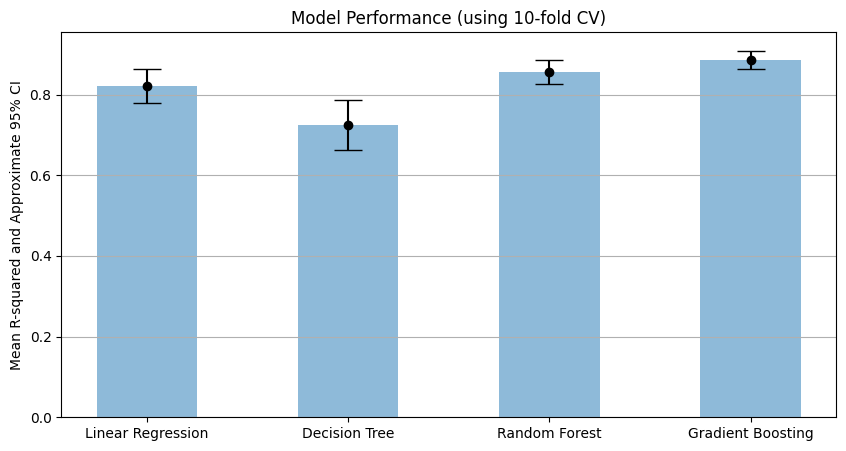

In [ ]:
# plot score means and variances on a bar chart with a line for the variance
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
means = [scores_ls.mean(), scores_dt.mean(), scores_rf.mean(), scores_gb.mean()]
stderrors = [scores_ls.std(), scores_dt.std(), scores_rf.std(), scores_gb.std()] / np.sqrt(k)

fig, ax = plt.subplots(figsize=(10, 5))
#ax.bar(models, means, yerr=variances, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.bar(models, means, align='center', alpha=0.5, ecolor='black', capsize=10, width=0.5)
ax.errorbar(models, means, yerr=1.96*stderrors, fmt='o', color='black', ecolor='black', capsize=10)
ax.set_ylabel(f'Mean R-squared and Approximate 95% CI')
ax.set_title(f'Model Performance (using {k}-fold CV)')
ax.yaxis.grid(True)
plt.show()

Although we have a relatively small sample size to estimate $R^2$ (in this case, k, the number of folds) we can still use the typical approach to point estimation and standard errors to get an idea of what the 95% confidence interval is. The above plot shows the mean $R^2$ and approximate confidence intervals. Confirming what we suspected before, it does seem that the Gradient Boosting Tree(s) is the best choice.

### Thorough Model Tuning
As you can imagine, just eyeballing the best hyperparameter value for a model based on curves like the ones we plotted above is not the most scientific. Oftentimes, once we have selected a model, we will want to try several different hyperparameter values, and perhaps combinations of the various hyperparameters associated with a model.

For Gradient Boosting there are two important hyperparameters:
* num_estimators - number of trees (linked together sequentially)
* learning_rate - the amount of importance/weight each successive tree will decrease by

We'll now use `GridSearch Cross-validation` to find the best values of these hyperparameters in a more robust way than we did earlier.

In [ ]:
# Okay, use grid search to find the best hyperparameters for the Gradient Boosting Regressor
param_grid = {
    'n_estimators': list(range(1, 402, 50)),
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.5]
}

model_gb = GradientBoostingRegressor(random_state=2)
grid_search = GridSearchCV(model_gb, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

print(f"** Best R2 = {grid_search.best_score_:1.2E} **")
print(f"** Best Parameters = {grid_search.best_params_} **")

It looks like a learning rate of 0.05 and ~400 trees will give us the best possible model. Let's now plot all the $R^2$ values for each combination of hyperparameter values that were tried.

In [ ]:
# plot a heatmap of the R2 values for the different hyperparameters
results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(len(param_grid['n_estimators']), len(param_grid['learning_rate']))

plt.figure(figsize=(8, 6))
plt.imshow(scores, cmap='viridis')
#plt.imshow(scores, interpolation='nearest', cmap='viridis')
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
plt.colorbar()
plt.xticks(np.arange(len(param_grid['learning_rate'])), param_grid['learning_rate'], rotation=45)
plt.yticks(np.arange(len(param_grid['n_estimators'])), param_grid['n_estimators'])
plt.title('R2')
plt.show()

***
### Q5: You should now have a good level of understanding of selecting and tuning a model. For this last question, go ahead and try out a new model type of your choice. Do **not** use one of the models above, but instead select one from the list below. Once you've done that, go ahead and run `grid search cross-validation` on the model and see if you can find one that fits the data better than the Gradient Boosting Tree above. The qustion is then, what is the peformance of your model? (i.e. what is the $R^2$?)

Ran out of time so turning in what I have done to get some credit.  Will come back and complete later on my own.
***

Here is a list of models that we have not explicitly talked about in class (although most are specialized versions of linear models or boosting ensemble models):

* [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)
* [ExtraTreesRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesRegressor.html)
* [HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html#sklearn.ensemble.HistGradientBoostingRegressor)
* [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor) - we looked at K-nearest neighbors, so this might be a good one to try, remember what the hyperparameter $k$ does when it comes to increasing/decreasing model complexity
* [Linear Models with automatica Variable Selection](https://scikit-learn.org/stable/api/sklearn.linear_model.html#regressors-with-variable-selection) - we won't cover these much, but this is something you would discuss in a Statistical Methods course, or other course on traditional statistical modeling methods
* [Support Vector Regression](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) - we haven't yet talked about Support Vector Machines but you can still use it here if you want to experiment

In [ ]:
# import the new model you have chosen

# declare an instance of your model
model_xx =


In [ ]:
# set up a grid or range of hyperparameter values to search over
param_grid = {

}

In [ ]:
# use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(model_xx, param_grid, cv=5, scoring='r2')
grid_search.fit(X, y)

print(f"** Best R2 = {grid_search.best_score_:1.2E} **")
print(f"** Best Parameters = {grid_search.best_params_} **")

Note that if you want to do a little bit extra to make your model even better, you could try one (or both) of the following:
1. Add some of the categorical features that were left out earlier, which you'll likely need to encode the same way we did above with `Neighborhood`
2. Do some more feature engineering to create new features from the existing ones (e.g. interactions, new categorical variables based on old ones, etc.)